In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pingouin import kruskal
import scikit_posthocs as sp
import os

In [54]:
parser = argparse.ArgumentParser(description='TFBS_coverage_plots')
parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
parser.add_argument('bp_covered_file', type=str, help='Input location of promoters bp_covered txt file')
parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '')
args = parser.parse_args()

NameError: name 'argparse' is not defined

In [2]:
dependent_variable = 'TFBS_coverage'

file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
bp_covered_file = f'../../data/output/{file_names}/{dependent_variable}/promoters_5UTR.bp_covered.txt'
output_folder_name = ''

In [ ]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")
    

In [3]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_coverage/plots  already exists


In [4]:
def read_bp_covered_file(bp_covered_file):
    """read in the bp_covered_file to a df"""
    coverage_df = pd.read_table(bp_covered_file, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot','strand','source', 'type', 'dot2', 'details', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered']
    coverage_df.columns = col
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df.fraction_bases_covered * 100

    #remove unnecessary columns
    coverage_df_reduced_columns = coverage_df[['chr','start','stop','AGI','strand', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered','percentage_bases_covered']]
    return coverage_df_reduced_columns

In [5]:
def merge_coverage_genecategories(bp_covered_df, gene_categories_file):
    """merged the bp_covered_df with the gene categories"""
    gene_cats = pd.read_table(gene_categories_file, sep='\t', header=None)
    cols = ['AGI','gene_type']
    gene_cats.columns = cols
    merged = pd.merge(gene_cats,bp_covered_df, on='AGI', how='left')
    return merged

In [6]:
def all_prom_distribution(GC_content_df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters GC content"""    
    
    dist_plot = GC_content_df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_distribution.pdf', format='pdf')

In [7]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    plot = sns.catplot(x=x_variable, y=y_variable, data=df, kind=plot_kind)
    #plot points
    ax = sns.swarmplot(x=x_variable, y=y_variable, data=df, color=".25")
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [8]:
#Read in bp_covered file
bp_covered_df = read_bp_covered_file(bp_covered_file)
#merge bp_covered_df with Czechowski gene categories
bp_covered_Czechowski_gene_categories = merge_coverage_genecategories(bp_covered_df, Czechowski_gene_categories)

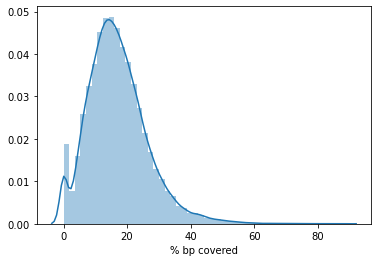

In [9]:
#all promoters TFBS distribution plot
all_prom_distribution(bp_covered_df, 'percentage_bases_covered', '% bp covered', f'{dependent_variable}_allproms')

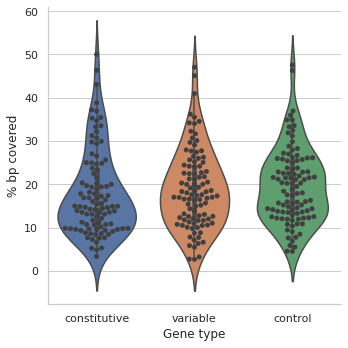

In [10]:
#Czechowski_gene_categories violin plot
make_plot(bp_covered_Czechowski_gene_categories,'gene_type','percentage_bases_covered','Gene type','% bp covered', f'Czechowski_{dependent_variable}', 'violin')

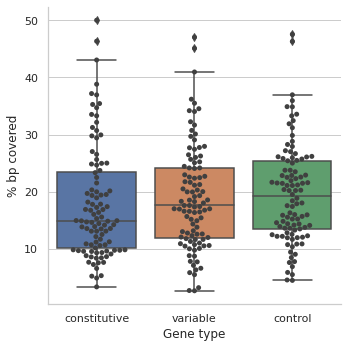

In [11]:
#Czechowski_gene_categories box plot
make_plot(bp_covered_Czechowski_gene_categories,'gene_type','percentage_bases_covered','Gene type','% bp covered', f'Czechowski_{dependent_variable}', 'box')

In [12]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [13]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [14]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [15]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)    

In [16]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [17]:
df = bp_covered_Czechowski_gene_categories
dependent_variable = 'percentage_bases_covered'
between_variable = 'gene_type'

In [18]:
test_normality(df,dependent_variable,between_variable)

constitutive: (0.9051100015640259, 2.478461055943626e-06)
variable: (0.9682794809341431, 0.016347475349903107)
control: (0.9640613198280334, 0.00791579857468605)


### not normal

In [19]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=0.1820847402452296, pvalue=0.8336236821365071)

### fail to reject null hypothesis that variances are equal

In [20]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,100.0,17.912134,9.902130,3.33642,10.067360,14.906640,23.423168,50.00000
control,100.0,19.626699,8.613524,4.47344,13.429240,19.175055,25.422407,47.55784
variable,100.0,18.892264,9.120471,2.65568,11.926013,17.583175,24.226887,47.04370


In [21]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,4.378583,0.111996


### no significant difference

In [22]:
#dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,0.118471,0.528823
control,0.118471,-1.000000,1.000000
variable,0.528823,1.000000,-1.000000


# no significant difference with post-hocs